In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
N=100 #number of samples
L=1000 #number of values for each sin wave
T=20 #width of the wave

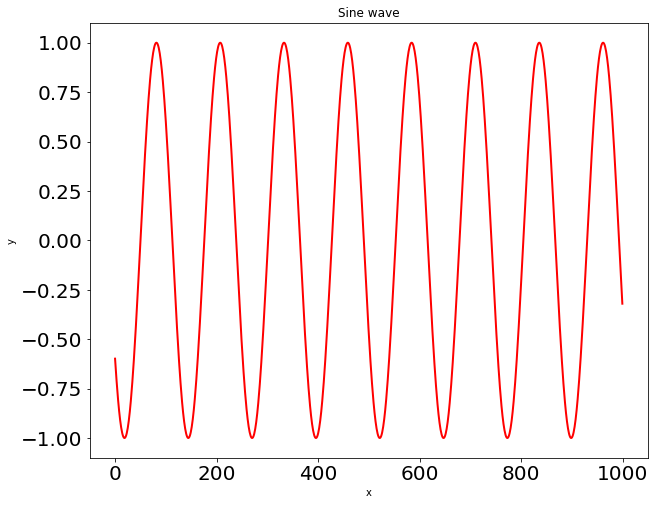

In [5]:
x=np.empty((N,L),np.float32)
#initialize N arrays with values between 0 and L-1 
#add to each array a random number between -4*T and +4*T
x[:]=np.array(range(L))+np.random.randint(-4*T,+4*T,N).reshape(N,1)

y=np.sin(x/T)

plt.figure(figsize=(10,8))
plt.title('Sine wave')
plt.xlabel('x')
plt.ylabel('y')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.plot(np.arange(x.shape[1]),y[0,:],'r',linewidth=2.0)
plt.plot(range(L),y[0,:],'r',linewidth=2.0)
plt.show()


In [6]:
class LSTMPredictor(nn.Module):
    def __init__(self,n_hidden=51):
        super().__init__()
        self.n_hidden=n_hidden
        #lstm1, lstm2, linear
        self.lstm1=nn.LSTMCell(1,self.n_hidden)
        self.lstm2=nn.LSTMCell(self.n_hidden,self.n_hidden)
        self.linear=nn.Linear(self.n_hidden,1)
    
    def forward(self,x,future=0):
        # the parameter future indicates the number of next predictions
        # es
        # future=100 we want to predict the next 100 values
        # future=0 no future prediction, only training on the values that we know
        outputs=[]
        n_samples=x.size(0)

        #hidden state lstm1
        h_t=torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
        #cell state lstm1
        c_t=torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
        #hidden state lstm2
        h_t2=torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)
        #cell state lstm2
        c_t2=torch.zeros(n_samples,self.n_hidden,dtype=torch.float32)

        for input_t in x.split(1,dim=1):
            # torch.split splits the tensor into chunks. Each chunk is a view of the original tensor.
            # if x has dimensions (N,100) than each chunks has dimensions (N,1)
            # we split x value by value along the columns

            h_t,c_t=self.lstm1(input_t,(h_t,c_t))
            h_t2,c_t2=self.lstm2(h_t,(h_t2,c_t2))
            output= self.linear(h_t2)
            outputs.append(output)
        
        for i in range(future):
            #the input of the first lstm is the the last value of the outputs
            h_t,c_t=self.lstm1(output,(h_t,c_t)) 
            h_t2,c_t2=self.lstm2(h_t,(h_t2,c_t2))
            output= self.linear(h_t2)
            outputs.append(output)

        outputs=torch.cat(outputs, dim=1)
        return outputs    

In [7]:
#we have the values of the previous prediction
# and we want the value of the next prediction
# the target values are the same array but shifted of one to the right 
# y = 100,1000
train_input=torch.from_numpy(y[3:,:-1]) #97, 999
train_target=torch.from_numpy(y[3:,1:]) #97, 999

test_input=torch.from_numpy(y[:3,:-1]) #3, 999
test_target=torch.from_numpy(y[:3,1:]) #3, 999

model=LSTMPredictor()
criterion=nn.MSELoss()

optimizer=optim.LBFGS(model.parameters(),lr=0.8)


n_steps=10

for i in range(n_steps):
    print('Step',i+1)

    def closure():
        optimizer.zero_grad()
        out=model(train_input)
        loss=criterion(out,train_target)
        print('Train loss',loss.item())
        loss.backward()
        return loss
    
    optimizer.step(closure)

    with torch.no_grad():
        future=1000
        pred=model(test_input,future=future)
        loss=criterion(pred[:,:-future],test_target)  #we have to exclude the future predictions
        print('Test loss',loss.item())
    
        y=pred.detach().numpy()
    
        plt.figure(figsize=(12,6))
        plt.title(f'Step {i+1}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
    
        n= train_input.shape[1]
    
        def draw(y_i,color):
            plt.plot(np.arange(n),y_i[:n],color,linewidth=2.0)
            plt.plot(np.arange(n,n+future),y_i[n:],color + ':',linewidth=2.0)
    
        draw(y[0],'r')
        draw(y[1],'b')
        draw(y[2],'g')
    
        plt.savefig('predict%d.pdf'%i,format='pdf')
        plt.close()

Step 1
Train loss 0.5064124464988708
Train loss 0.503570020198822
Train loss 0.45999330282211304
Train loss 0.3638867139816284
Train loss 2882.29736328125
Train loss 21.612911224365234
Train loss 6.604034423828125
Train loss 0.20456264913082123
Train loss 0.08027628064155579
Train loss 0.05729754641652107
Train loss 0.047860078513622284
Train loss 0.039625104516744614
Train loss 0.03087601065635681
Train loss 0.026901302859187126
Train loss 0.024648072198033333
Train loss 0.02342919632792473
Train loss 0.021504061296582222
Train loss 0.01789005659520626
Train loss 0.011947199702262878
Train loss 0.00583588145673275
Test loss 0.0033878337126225233
Step 2
Train loss 0.00343983992934227
Train loss 0.0026471903547644615
Train loss 0.0020338415633887053
Train loss 0.0022752974182367325
Train loss 0.001188774942420423
Train loss 0.0010536628542467952
Train loss 0.0010090820724144578
Train loss 0.0009418770205229521
Train loss 0.0008461230318062007
Train loss 0.0006956385332159698
Train loss 